## ML기반전략의 백테스트 방법
> 머신러닝을 활용, 트레이딩 신호를 생성하고 포지션 선택, 조정 및 백테스트 통한 거래집행 최적화. 관련한 절차를 알아보자
1. 시장, 기본적 및 대체 데이터 출처와 준비 
2. 예측 알파팩터 선정과 피쳐엔지니어링
3. ML 모델을 설계, 튜닝, 평가해 트레이딩 신호생성 
4. 예를 들어 규칙을 적용해 이러한 신호에 따라 거래 결정 
5. 포트폴리오 맥락에서 개별 포지션의 크기 조정 
6. 과거 시장 데이터를 사용해 발생한 트레이딩 시뮬레이션 
7. 최종 포지션이 어떻게 수행됐는지의 평가

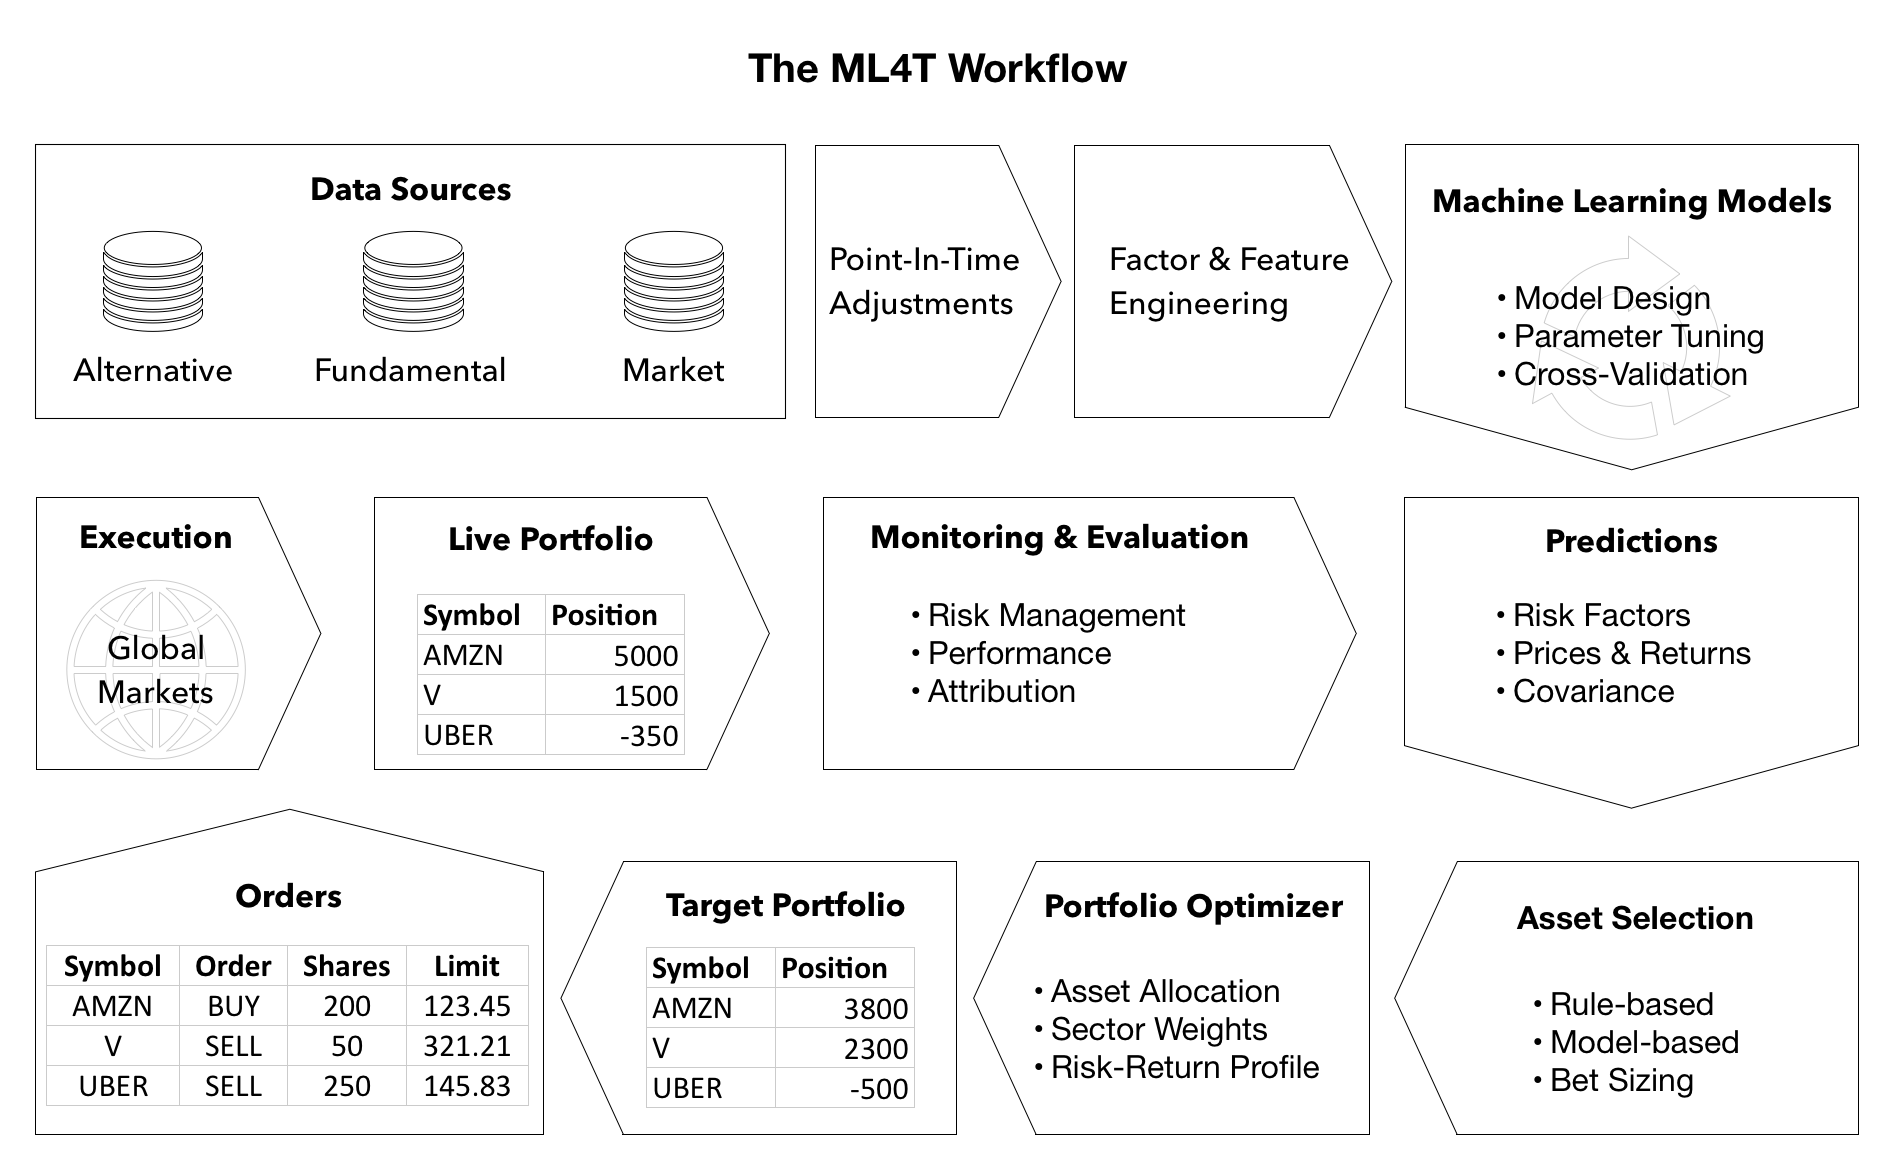

## 백테스트의 단점과 이를 회피하는 방법

- 모델의 일반화

ML 프로세스에서 모델의 학습은 새로운 응용에 잘 일반화돼야 한다. 즉, 주어진 데이터 세트에 대해 훈련된 ML 모델의 예측은 새 입력 데이터를 제공할 때에도 동일하게 잘 수행돼야 한다.

- 백테스팅의 중요성

전략의 백테스트 성과는 미래 시장 성과를 나타내야 한다. 문제를 제대로 해결하지 못하면 결과를 신뢰할 수 없게 되고 전략의 실제 구현에 대해 잘못된 의사결정으로 이어진다.

- 방법론적 과제

백테스팅 엔진이 과거 시뮬레이션을 실행하는 방법을 살펴보기 전에 몇 가지 검토할 과제가 있다.


### 올바른 데이터인가??
> 백테스트의 유효성을 저해하는 데이터문제로 선견편향,생존편향, 특이값제거, 표본기간의 선택의 문제가 있다

- 선견편향 : 과거시점의 데이터라서 미래관점을 반영 못함, 사업구조 변화 등
- 생존편향 : 사라진 자산(폐지/인수 등) 생략하고 활성화 증권 대상 문제, 경우에 따라 포함 필요
- 특이값제거 : 클리핑으로 극단치를 제외하면, 펫테일분포의 시장을 반영어려움, 특이값도 주의깊게 분석하며 현실에 맞게 전략파라미터 조정 필요
- 표본기간의 선택 : 표본 데이터가 현재의 변동성/거래량 반영 못하는 경우, 시장상황을 반영하는 합성데이터 생성 필요

    


### 시뮬레이션을 올바르게 수행하였나??
> 과거 시뮬레이션의 구현과 관련, 시장가격/인출을 정확히 반영하는 시가평가를 반영하였나, 거래가용성/시장충격에 대한 비현실적 가정은 없나, 신호와 거래집행 타이밍이 어긋나진 않는가?
- 시가평가 성과 : 지금만 수익나는 것이 아닌 시간이 지나도 통용되도록 실시간으로 추적 필요 (VaR, 소르티노 비율과 같은 롤링 리스크 척도 계산 병행)
- 거래비용 : 현실적 트레이딩 환경 (수수료, 슬리피지) 고려하여 백테스트 수행
- 의사결정 타이밍 : 거래시점 매칭되도록 신호도착, 거래실행 성과평가 순서 신중히 조정

### 올바른 통계량을 얻었나?
> 동일한 데이터에 대해 여러 전략을 테스트하면 우연히 좋은 성과를 보이는 전략이 선택될 수 있음(과대적합), 투자/경제 이론으로 정당화된 테스트에 우선순위 부여하거나  다양한 맥락/시나리오(합성데이터 포함)에서 테스트하려는 노력이 필요하다

- 백테스트기간의최소길이와축소샤프비율
마르코스 로페즈 데 프라도는 
백테스트의위험성과 백테스트과대적합의 위험성을 알렸다 [관련문서1](https://www.ams.org/notices/201405/rnoti-p458.pdf) [관련문서2. 온라인 시뮬레이터](https://datagrid.lbl.gov/backtest/)

- 주어진 수의 표본테스트에 특정 SR을 달성하지만 표본 외에는 SR 기대값 0인 전략을 선택하지 않으려, 투자자가 요구해야 하는 백테스트의 최소길이의 추정치 포함
    - 결과: 2년간의 일일 백테스트는 7개를 넘는 전략에 대한 결론을 지지하지 않았음. 5년의 데이터인 경우 45가지 전략변형으로 확장

- 베일리와 프라도(2014)는 축소SR을 도출 / 다중테스트,비정규분포수익률,짧은 표본길이의 증폭효과를 제어하면서 SR이 통계적으로 유의할확률을 계산했다 (Deflatedf_sharpe_ratio)

- 백테스트의 최적종료 (Optimal Stopping) : 첫번째 최적후보를 거부한 다음, 이전 모든 옵션을 능가하는 첫번째 후보를 선택 (면접보듯)
    + 합리적 전략의 무작위 표본을 테스트/성능기록, 우수할 때까지 테스트

## 백테스트엔진 작동법
- 백테스트 엔진은 과거가격에 대해 반복함벼, 현재 값을 모델에 전달하며 그 대가로 주문을 받고 결과포지션과 이 값을 추적
> 벡터화 접근법과 이벤트 기반 접근법의 차이는 트레이닝 환경의 충실한 복제가 어떻게 상당한 복잡도를 가중하는지 보여주

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from pathlib import Path
from time import time
import datetime

import numpy as np
import pandas as pd
import pandas_datareader.data as web

from scipy.stats import spearmanr

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [4]:
sns.set_style('whitegrid')
np.random.seed(42)

### SP500 Benchmark

In [5]:
sp500 = web.DataReader('SP500', 'fred', '2014', '2018').pct_change()

### Return Predictions

In [6]:
DATA_DIR = Path('..', 'data')

In [13]:
with pd.HDFStore('d:/drive/SelfStudy/Quant/Source/data/assets.h5') as store:
        prices = (store['quandl/wiki/prices']
                  .filter(like='adj')
                  .rename(columns=lambda x: x.replace('adj_', ''))
                  .swaplevel(axis=0))

In [15]:
with pd.HDFStore(PROJECT_DIR / '07_linear_models/data.h5') as store:
        print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: ..\07_linear_models\data.h5
Empty


In [20]:
with pd.HDFStore('d:/drive/SelfStudy/Quant/Source/data/assets.h5') as store:
        prices = (store['quandl/wiki/prices']
                  .filter(like='adj')
                  .rename(columns=lambda x: x.replace('adj_', ''))
                  .swaplevel(axis=0))

with pd.HDFStore(PROJECT_DIR / '07_linear_models/data.h5') as store:
    print(store.info())
    predictions = store['lasso/predictions']

best_alpha = predictions.groupby('alpha').apply(lambda x: spearmanr(x.actuals, x.predicted)[0]).idxmax()
predictions = predictions[predictions.alpha == best_alpha]
predictions.index.names = ['ticker', 'date']
tickers = predictions.index.get_level_values('ticker').unique()

<class 'pandas.io.pytables.HDFStore'>
File path: ..\07_linear_models\data.h5
/lasso/coeffs                 frame        (shape->[8,33])      
/lasso/predictions            frame        (shape->[121840,3])  
/lasso/scores                 frame        (shape->[12472,3])   
/lr/predictions               frame        (shape->[15230,2])   
/lr/scores                    frame        (shape->[1559,2])    
/model_data                   frame        (shape->[2904233,69])
/ridge/coeffs                 frame        (shape->[18,33])     
/ridge/predictions            frame        (shape->[274140,3])  
/ridge/scores                 frame        (shape->[28062,3])   


In [28]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
__author__ = 'Stefan Jansen'

from pathlib import Path
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)

PROJECT_DIR = Path('..')

DATA_DIR = PROJECT_DIR / 'data'


def get_backtest_data(predictions='lasso/predictions'):
    """Combine chapter 7 lr/lasso/ridge regression predictions
        with adjusted OHLCV Quandl Wiki data"""
    with pd.HDFStore('d:/drive/SelfStudy/Quant/Source/data/assets.h5') as store:
        prices = (store['quandl/wiki/prices']
                  .filter(like='adj')
                  .rename(columns=lambda x: x.replace('adj_', ''))
                  .swaplevel(axis=0))

    with pd.HDFStore(PROJECT_DIR / '07_linear_models/data.h5') as store:
        print(store.info())
        predictions = store[predictions]

    best_alpha = predictions.groupby('alpha').apply(lambda x: spearmanr(x.actuals, x.predicted)[0]).idxmax()
    predictions = predictions[predictions.alpha == best_alpha]
    predictions.index.names = ['ticker', 'date']
    tickers = predictions.index.get_level_values('date').unique()
    start = predictions.index.get_level_values('ticker').min().strftime('%Y-%m-%d')
    stop = (predictions.index.get_level_values('ticker').max() + pd.DateOffset(1)).strftime('%Y-%m-%d')
    idx = pd.IndexSlice
    prices = prices.sort_index().loc[idx[tickers, start:stop], :]
    predictions = predictions.loc[predictions.alpha == best_alpha, ['predicted']]
    return predictions.join(prices, how='right')


df = get_backtest_data('lasso/predictions')
print(df.info())
df.to_hdf('backtest.h5', 'data')

<class 'pandas.io.pytables.HDFStore'>
File path: ..\07_linear_models\data.h5
/lasso/coeffs                 frame        (shape->[8,33])      
/lasso/predictions            frame        (shape->[121840,3])  
/lasso/scores                 frame        (shape->[12472,3])   
/lr/predictions               frame        (shape->[15230,2])   
/lr/scores                    frame        (shape->[1559,2])    
/model_data                   frame        (shape->[2904233,69])
/ridge/coeffs                 frame        (shape->[18,33])     
/ridge/predictions            frame        (shape->[274140,3])  
/ridge/scores                 frame        (shape->[28062,3])   
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 252357 entries, ('AAL', Timestamp('2013-07-03 00:00:00')) to ('YUM', Timestamp('2017-11-30 00:00:00'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   predicted  0 non-null       float64
 1   open       252357 non-nul

In [31]:
data = pd.read_hdf('d:/drive/SelfStudy/Quant/Source/08_ml4t_workflow/backtest.h5')
data

predicted       open       high        low      close       volume
ticker date                                                                          
AAL    2013-07-03        NaN  41.729374  43.652147  41.677407  43.522230  2625799.894
       2013-07-05        NaN  43.989932  44.171816  43.340346  43.756081  2397200.130
       2013-07-08        NaN  44.015915  44.405667  43.782064  44.015915  2671199.962
       2013-07-09        NaN  44.197799  45.159186  44.093866  45.107219  4076600.179
       2013-07-10        NaN  45.003285  45.419020  44.197799  44.613534  4289699.928
...                      ...        ...        ...        ...        ...          ...
YUM    2017-11-24        NaN  79.250000  79.710000  79.140000  79.180000   682543.000
       2017-11-27        NaN  79.220000  79.700000  79.130000  79.580000  1109793.000
       2017-11-28        NaN  79.840000  81.130000  79.700000  81.030000  1706520.000
       2017-11-29        NaN  81.290000  82.120000  81.200000  81.810000  1658544.000
       2017-11-30        NaN  82.070000  84.060000  81.780000  83.470000  3021182.000

[252357 rows x 6 columns]

In [32]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 954 entries, 2014-05-07 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SP500   953 non-null    float64
dtypes: float64(1)
memory usage: 14.9 KB


### Compute Forward Returns

In [33]:
daily_returns = data.open.unstack('ticker').sort_index().pct_change()
daily_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1113 entries, 2013-07-03 to 2017-11-30
Columns: 229 entries, AAL to YUM
dtypes: float64(229)
memory usage: 2.0 MB


In [34]:
fwd_returns = daily_returns.shift(-1)

### Generate Signals

In [35]:
predictions = data.predicted.unstack('ticker')
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1113 entries, 2013-07-03 to 2017-04-14
Columns: 229 entries, AAL to YUM
dtypes: float64(229)
memory usage: 2.0 MB


In [36]:
N_LONG = N_SHORT = 15

In [37]:
long_signals = ((predictions
                .where(predictions > 0)
                .rank(axis=1, ascending=False) > N_LONG)
                .astype(int))
short_signals = ((predictions
                  .where(predictions < 0)
                  .rank(axis=1) > N_SHORT)
                 .astype(int))

### Compute Portfolio Returns

In [38]:
long_returns = long_signals.mul(fwd_returns).mean(axis=1)
short_returns = short_signals.mul(-fwd_returns).mean(axis=1)
strategy = long_returns.add(short_returns).to_frame('Strategy')

### Plot results

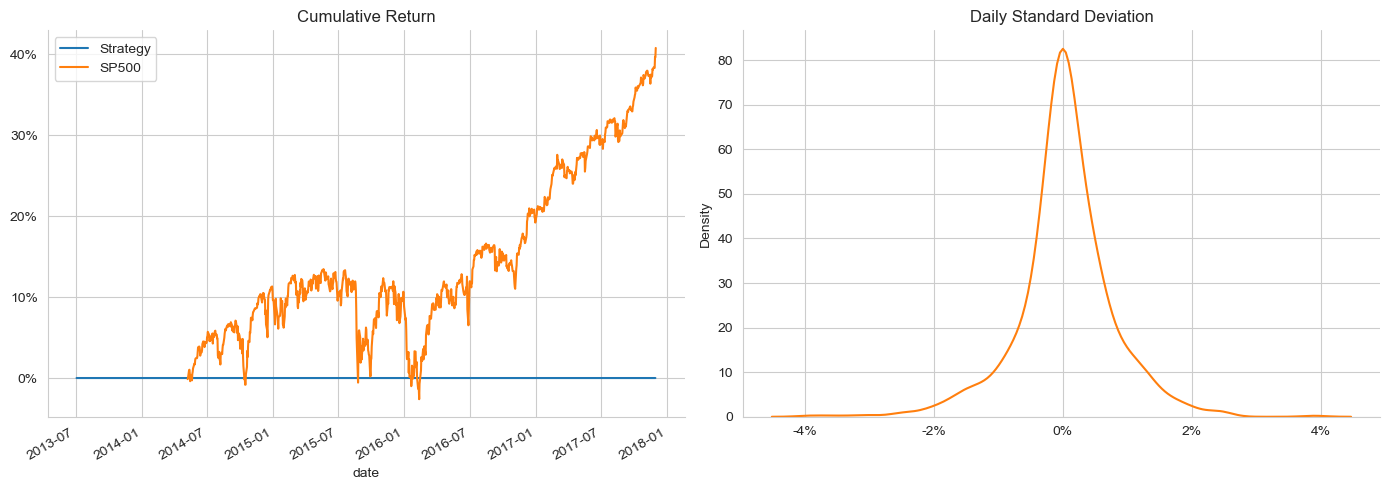

In [39]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
strategy.join(sp500).add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
sns.distplot(strategy.dropna(), ax=axes[1], hist=False, label='Strategy')
sns.distplot(sp500, ax=axes[1], hist=False, label='SP500')
axes[1].set_title('Daily Standard Deviation')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
sns.despine()
fig.tight_layout();

In [40]:
res = strategy.join(sp500).dropna()

In [41]:
res.std()

Strategy    0.000000
SP500       0.007694
dtype: float64

In [42]:
res.corr()

,Strategy,SP500
Strategy,NaN,NaN
SP500,NaN,1.0


# ML4T작업흐름 : 모델에서 전략 백테스트까지
- 지금까지 배운 ML4T워크플로우를 통합하여 다룬다
> ML알고리즘에 의해 구동되는 트레이딩 전략을 평가하는 프로세스에 대한 엔드투엔드 관점을 제시하는 것
- 엔드투엔드 전략 백테스트 계획과 구현
- 백테스트 구현시 중요한 함정의 이해와 방지
- 백테스트 엔진과 이벤트 기반 백테스트 엔진의 장점과 단점에 대한 설명
- 이벤트 기반 백테스터의 주요 구성 QA식별과 평가
- 훈련하거나 백테스트의 일환으로 훈련된 ML 모델을 이용해 분당 및 일일 빈도의 데이터 소스 사용, ML4T 워크플로 설계와 실행
- 집라인과 백트레이더 사용


## ML기반전략의 백테스트 방법
> 머신러닝을 활용, 트레이딩 신호를 생성하고 포지션 선택, 조정 및 백테스트 통한 거래집행 최적화. 관련한 절차를 알아보자
1. 시장, 기본적 및 대체 데이터 출처와 준비 
2. 예측 알파팩터 선정과 피쳐엔지니어링
3. ML 모델을 설계, 튜닝, 평가해 트레이딩 신호생성 
4. 예를 들어 규칙을 적용해 이러한 신호에 따라 거래 결정 
5. 포트폴리오 맥락에서 개별 포지션의 크기 조정 
6. 과거 시장 데이터를 사용해 발생한 트레이딩 시뮬레이션 
7. 최종 포지션이 어떻게 수행됐는지의 평가

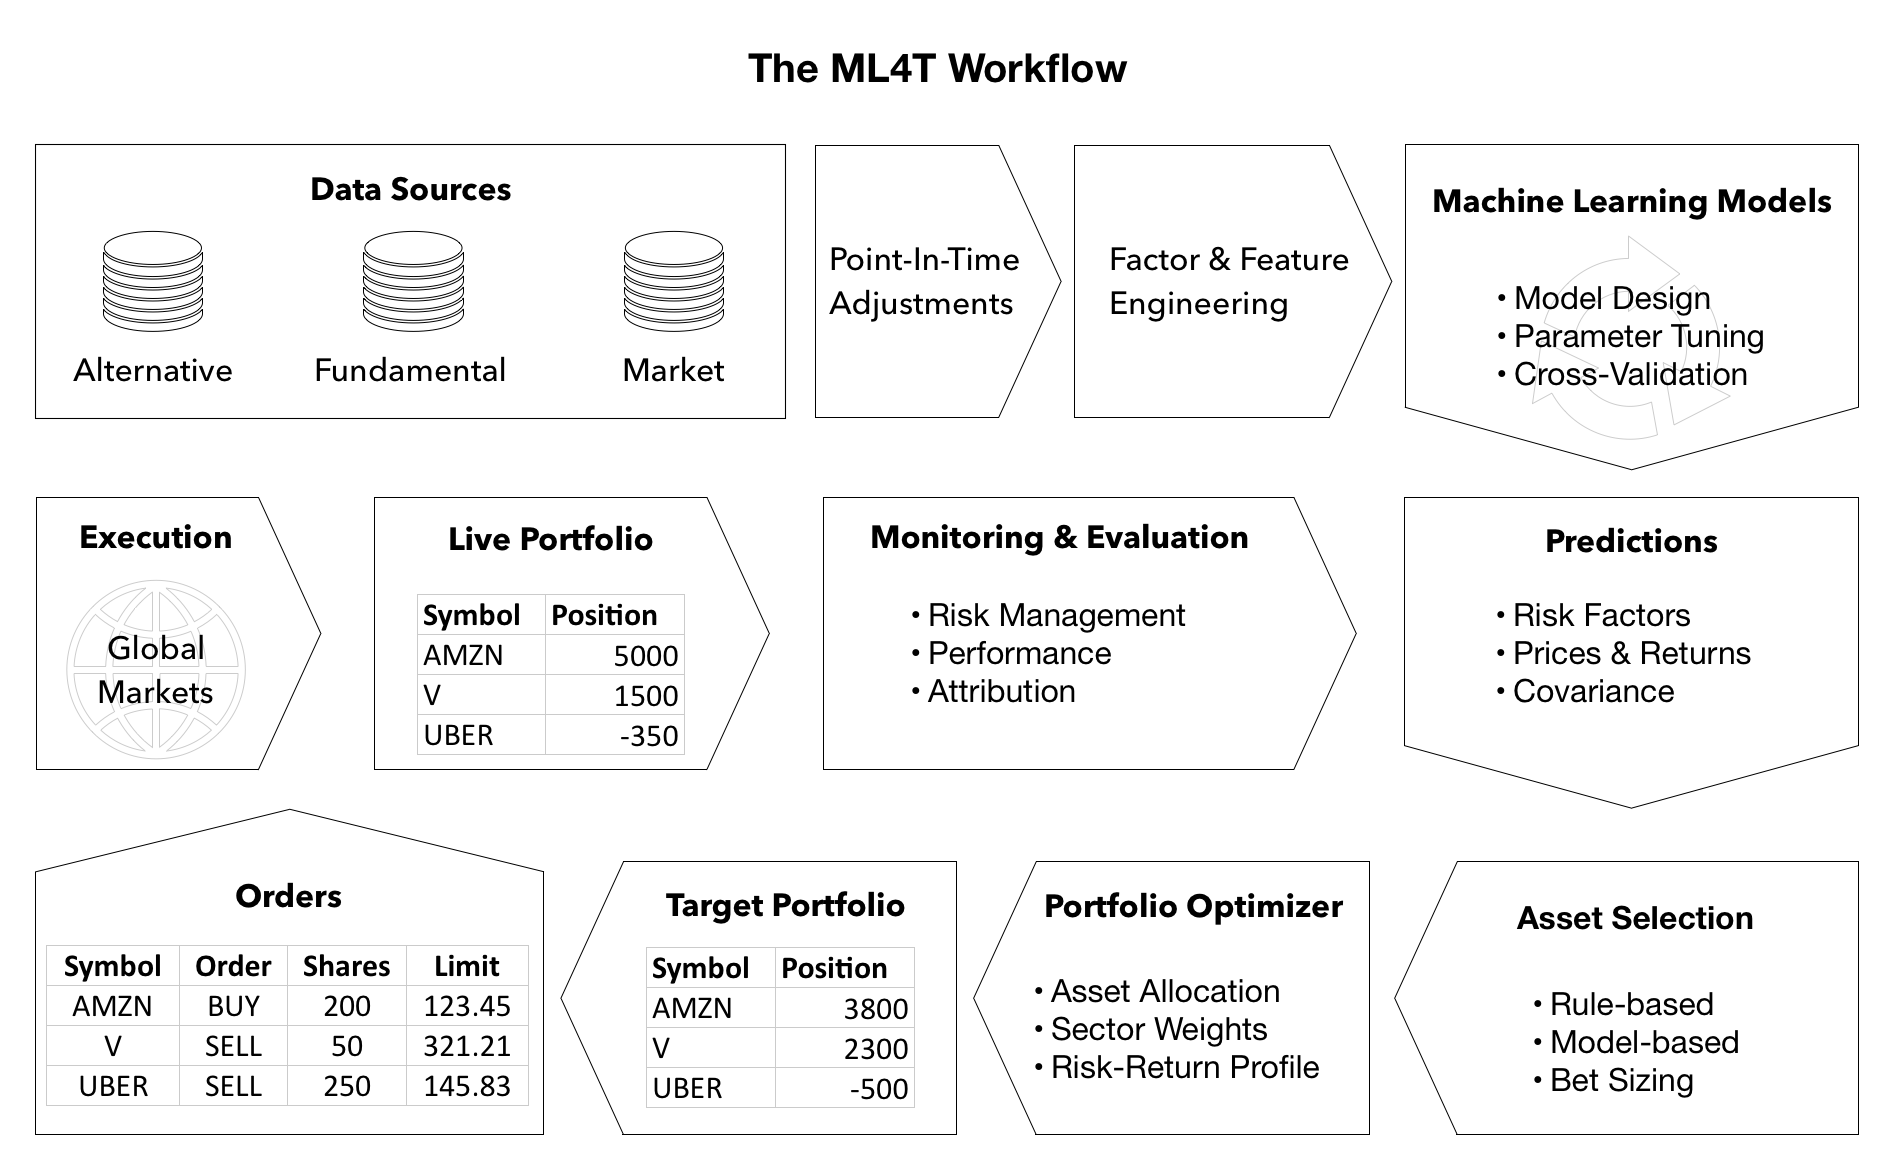

## 백테스트의 단점과 이를 회피하는 방법

- 모델의 일반화

ML 프로세스에서 모델의 학습은 새로운 응용에 잘 일반화돼야 한다. 즉, 주어진 데이터 세트에 대해 훈련된 ML 모델의 예측은 새 입력 데이터를 제공할 때에도 동일하게 잘 수행돼야 한다.

- 백테스팅의 중요성

전략의 백테스트 성과는 미래 시장 성과를 나타내야 한다. 문제를 제대로 해결하지 못하면 결과를 신뢰할 수 없게 되고 전략의 실제 구현에 대해 잘못된 의사결정으로 이어진다.

- 방법론적 과제

백테스팅 엔진이 과거 시뮬레이션을 실행하는 방법을 살펴보기 전에 몇 가지 검토할 과제가 있다.


### 올바른 데이터인가??
> 백테스트의 유효성을 저해하는 데이터문제로 선견편향,생존편향, 특이값제거, 표본기간의 선택의 문제가 있다

- 선견편향 : 과거시점의 데이터라서 미래관점을 반영 못함, 사업구조 변화 등
- 생존편향 : 사라진 자산(폐지/인수 등) 생략하고 활성화 증권 대상 문제, 경우에 따라 포함 필요
- 특이값제거 : 현실의 극단치를 제외하면, 펫테일분포의 시장을 반영 어려움, 특이값도 주의깊게 분석하며 현실에 맞게 전략파라미터 조정 필요
- 표본기간의 선택 : 표본 데이터가 현재의 변동성/거래량 반영 못하는 경우, 시장상황을 반영하는 합성데이터 생성 필요

    


### 시뮬레이션을 올바르게 수행하였나??
> 과거 시뮬레이션을 구현하는 과정에서, 시장가격/인출을 정확히 반영하는 시가평가를 반영하였나, 거래 비용/시장 충격에 대한 비현실적 가정은 없나, 신호와 거래집행 타이밍이 어긋나진 않는가?
- 시가평가 성과 : 지금만 수익나는 것이 아닌 시간이 지나도 통용되도록 실시간으로 추적 필요 
    + Value at Risk, 소르티노 비율과 같은 롤링 리스크 척도 계산 병행
- 거래비용 : 현실적 트레이딩 환경 (수수료, 슬리피지) 고려하여 백테스트 수행
- 의사결정 타이밍 : 거래시점 매칭되도록 신호 도착, 거래실행 성과평가 순서 신중히 조정 
    + 단순히 종가로 시뮬레이션 하면 현실적 미래 결과 나타내지 못하는 경우 발생

### 올바른 통계량을 얻었나?
> 동일한 데이터에 대해 여러 전략을 테스트하면 우연히 좋은 성과를 보이는 전략이 선택될 수 있음(과대적합), 투자/경제 이론으로 정당화된 테스트에 우선순위 부여하거나  다양한 맥락/시나리오(합성데이터 포함)에서 테스트하려는 노력이 필요하다

- 백테스트도 과대적합이 발생 가능
    +  [관련문서1](https://www.ams.org/notices/201405/rnoti-p458.pdf) [관련문서2. 온라인 시뮬레이터](https://datagrid.lbl.gov/backtest/)
    ```
    **백테스트 과적합(Overfitting)**과 그것이 **샘플 외 성능(Out-of-Sample Performance)**에 미치는 영향에 대해 다루고 있음
    - 백테스트의 정의: 알고리즘 투자 전략의 역사적 시뮬레이션으로, 해당 알고리즘이 그 기간 동안 실행되었다면 어떤 이익과 손실을 발생시켰을지를 계산
    - IS와 OOS 성능: ‘In-sample (IS)’ 성능은 전략 설계에 사용된 샘플에서 시뮬레이션된 성능이고, ‘Out-of-sample (OOS)’ 성능은 전략 설계에 사용되지 않은 샘플에서 시뮬레이션된 성능
    - 과적합의 문제: 재무 시리즈에서 수많은 잠재적 옵션을 체계적으로 검색함으로써 투자 전략을 과적합할 수 있으며, 이는 IS에서는 잘 작동하지만 OOS에서는 드물게 나타날 수 있는 특징에 이익을 얻게 됨
    - 과적합 방지: 연구자들은 백테스트 과적합을 방지하기 위해 필요한 최소 백테스트 길이(MinBTL)를 계산하고, 이를 통해 백테스트 성능의 신뢰성을 평가하는 벤치마크 방법론을 제공
    ```

- 주어진 수 표본테스트에 Sharpe Ratio를 달성하지만 표본 외에는 SR 기대값 0인 전략을 선택하지 않으려, 투자자가 요구해야 하는 백테스트의 최소길이의 추정치 포함
- 베일리와 프라도(2014)는 축소SR을 도출 / 다중테스트, 비정규분포수익률, 짧은 표본길이의 증폭효과를 제어하면서 SR 통계적 유의 확률 계산 [Deflated_sharpe_ratio 논문](https://www.davidhbailey.com/dhbpapers/deflated-sharpe.pdf)
- 백테스트의 최적종료 (Optimal Stopping) : 첫번째 최적후보를 거부한 다음, 이전 모든 옵션을 능가하는 첫번째 후보를 선택. 거짓 긍정의 리스크를 최소화하며 가능한 한 빨리 최선에 가까운 것을 목표호 하는 여러 대안 테스트에 적용
    + 합리적 전략의 무작위 표본을 테스트/성능기록, 우수할 때까지 테스트

In [1]:
'''
multiple test 실행하기 : 
'''

#!/usr/bin/env python
# On 20140607 by lopezdeprado@lbl.gov
from itertools import product

import numpy as np
import pandas as pd
import scipy.stats as ss


def get_analytical_max_sr(mu, sigma, num_trials):
    """Compute the expected maximum Sharpe ratio (Analytically)"""

    # Euler-Mascheroni constant
    emc = 0.5772156649

    maxZ = (1 - emc) * ss.norm.ppf(1 - 1. / num_trials) + emc * ss.norm.ppf(1 - 1 / (num_trials * np.e))
    return mu + sigma * maxZ


def get_numerical_max_sr(mu, sigma, num_trials, n_iter):
    """Compute the expected maximum Sharpe ratio (Numerically)"""
    max_sr, count = [], 0
    while count < n_iter:
        count += 1
        series = np.random.normal(mu, sigma, num_trials)
        max_sr.append(max(series))
    return np.mean(max_sr), np.std(max_sr)


def simulate(mu, sigma, num_trials, n_iter):
    """Get analytical and numerical solutions"""
    expected_max_sr = get_analytical_max_sr(mu, sigma, num_trials)
    mean_max_sr, stdmean_max_sr = get_numerical_max_sr(mu, sigma, num_trials, n_iter)
    return expected_max_sr, mean_max_sr, stdmean_max_sr


def main():
    n_iter, sigma, output, count = 1e4, 1, [], 0
    for i, prod_ in enumerate(product(np.linspace(-100, 100, 101), range(10, 1001, 10)), 1):
        if i % 1000 == 0:
            print(i, end=' ', flush=True)
        mu, num_trials = prod_[0], prod_[1]
        expected_max_sr, mean_max_sr, std_max_sr = simulate(mu, sigma, num_trials, n_iter)
        err = expected_max_sr - mean_max_sr
        output.append([mu, sigma, num_trials, n_iter,
                       expected_max_sr, mean_max_sr,
                       std_max_sr, err])
    output = pd.DataFrame(output,
                          columns=['mu', 'sigma', 'num_trials', 'n_iter',
                                   'expected_max_sr', 'mean_max_sr',
                                   'std_max_sr', 'err'])
    print(output.info())
    output.to_csv('DSR.csv')


# df = pd.read_csv('DSR.csv')
# print(df.info())
# print(df.head())

if __name__ == '__main__':
    main()


1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 <class 'pandas.core.frame.DataFrame'>
RangeIndex: 10100 entries, 0 to 10099
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mu               10100 non-null  float64
 1   sigma            10100 non-null  int64  
 2   num_trials       10100 non-null  int64  
 3   n_iter           10100 non-null  float64
 4   expected_max_sr  10100 non-null  float64
 5   mean_max_sr      10100 non-null  float64
 6   std_max_sr       10100 non-null  float64
 7   err              10100 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 631.4 KB
None


## 백테스트엔진 작동법
> 백테스트 엔진은 과거 가격(및 기타데이터)에 대해 반복 실행하면서 현재 값을 알고리즘에 전달하며, 그 대가로 주문을 받고 결과 포지션들과 이들의 값을 추적한다.


In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
from pathlib import Path
from time import time
import datetime

import numpy as np
import pandas as pd
import pandas_datareader.data as web

from scipy.stats import spearmanr

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [19]:
sns.set_style('whitegrid')
np.random.seed(42)

### SP500 Benchmark

In [20]:
sp500 = web.DataReader('SP500', 'fred', '2014', '2018').pct_change()

### Return Predictions

In [21]:
DATA_DIR = Path('..', 'data')

In [22]:
data = pd.read_hdf('d:/drive/SelfStudy/Quant/Source/08_ml4t_workflow/backtest.h5')
data

predicted       open       high        low      close  \
ticker date                                                                
AAL    2013-07-03        NaN  41.729374  43.652147  41.677407  43.522230   
       2013-07-05        NaN  43.989932  44.171816  43.340346  43.756081   
       2013-07-08        NaN  44.015915  44.405667  43.782064  44.015915   
       2013-07-09        NaN  44.197799  45.159186  44.093866  45.107219   
       2013-07-10        NaN  45.003285  45.419020  44.197799  44.613534   
...                      ...        ...        ...        ...        ...   
YUM    2017-11-24        NaN  79.250000  79.710000  79.140000  79.180000   
       2017-11-27        NaN  79.220000  79.700000  79.130000  79.580000   
       2017-11-28        NaN  79.840000  81.130000  79.700000  81.030000   
       2017-11-29        NaN  81.290000  82.120000  81.200000  81.810000   
       2017-11-30        NaN  82.070000  84.060000  81.780000  83.470000   

                        volume  
ticker date                     
AAL    2013-07-03  2625799.894  
       2013-07-05  2397200.130  
       2013-07-08  2671199.962  
       2013-07-09  4076600.179  
       2013-07-10  4289699.928  
...                        ...  
YUM    2017-11-24   682543.000  
       2017-11-27  1109793.000  
       2017-11-28  1706520.000  
       2017-11-29  1658544.000  
       2017-11-30  3021182.000  

[252357 rows x 6 columns]

In [23]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 954 entries, 2014-05-07 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SP500   953 non-null    float64
dtypes: float64(1)
memory usage: 14.9 KB


### Compute Forward Returns

In [24]:
daily_returns = data.open.unstack('ticker').sort_index().pct_change()
daily_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1113 entries, 2013-07-03 to 2017-11-30
Columns: 229 entries, AAL to YUM
dtypes: float64(229)
memory usage: 2.0 MB


In [25]:
fwd_returns = daily_returns.shift(-1)

### Generate Signals

In [26]:
predictions = data.predicted.unstack('ticker')
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1113 entries, 2013-07-03 to 2017-04-14
Columns: 229 entries, AAL to YUM
dtypes: float64(229)
memory usage: 2.0 MB


In [27]:
N_LONG = N_SHORT = 15

In [28]:
long_signals = ((predictions
                .where(predictions > 0)
                .rank(axis=1, ascending=False) > N_LONG)
                .astype(int))
short_signals = ((predictions
                  .where(predictions < 0)
                  .rank(axis=1) > N_SHORT)
                 .astype(int))

### Compute Portfolio Returns

In [29]:
long_returns = long_signals.mul(fwd_returns).mean(axis=1)
short_returns = short_signals.mul(-fwd_returns).mean(axis=1)
strategy = long_returns.add(short_returns).to_frame('Strategy')

### Plot results

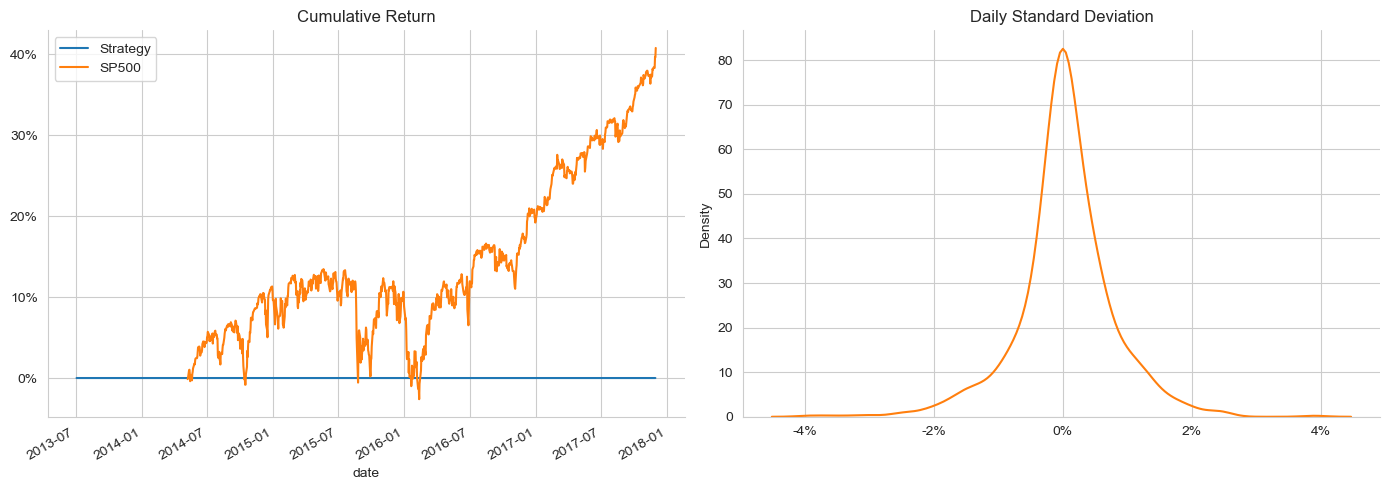

In [30]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
strategy.join(sp500).add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
sns.distplot(strategy.dropna(), ax=axes[1], hist=False, label='Strategy')
sns.distplot(sp500, ax=axes[1], hist=False, label='SP500')
axes[1].set_title('Daily Standard Deviation')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
sns.despine()
fig.tight_layout();

In [31]:
res = strategy.join(sp500).dropna()

In [32]:
res.std()

Strategy    0.000000
SP500       0.007694
dtype: float64

In [33]:
res.corr()

,Strategy,SP500
Strategy,NaN,NaN
SP500,NaN,1.0


# Backtesting an ML strategy with Backtrader

## Imports & Settings

In [34]:
import warnings
warnings.filterwarnings('ignore')

In [38]:
%matplotlib inline
#pip install backtrader pyfolio

from pathlib import Path
import csv
from time import time
import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns

import backtrader as bt
from backtrader.feeds import PandasData

import pyfolio as pf

In [39]:
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)
sns.set_style('darkgrid')

In [40]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

## Backtrader Setup

### Custom Commission Scheme

In [41]:
class FixedCommisionScheme(bt.CommInfoBase):
    """
    Simple fixed commission scheme for demo
    """
    params = (
        ('commission', .02),
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_FIXED),
    )

    def _getcommission(self, size, price, pseudoexec):
        return abs(size) * self.p.commission

### DataFrame Loader

In [42]:
OHLCV = ['open', 'high', 'low', 'close', 'volume']

In [62]:
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

### Strategy

Includes an option to only trade on certain weekdays in lines 39/40.

In [63]:
class MLStrategy(bt.Strategy):
    params = (('n_positions', 10),
              ('min_positions', 5),
              ('verbose', False),
              ('log_file', 'backtest.csv'))

    def log(self, txt, dt=None):
        """ Logger for the strategy"""
        dt = dt or self.datas[0].datetime.datetime(0)
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow([dt.isoformat()] + txt.split(','))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # broker could reject order if not enough cash
        if self.p.verbose:
            if order.status in [order.Completed]:
                p = order.executed.price
                if order.isbuy():
                    self.log(f'{order.data._name},BUY executed,{p:.2f}')
                elif order.issell():
                    self.log(f'{order.data._name},SELL executed,{p:.2f}')

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log(f'{order.data._name},Order Canceled/Margin/Rejected')

    # bt calls prenext instead of next unless
    # all datafeeds have current values
    # => call next to avoid duplicating logic
    def prenext(self):
        self.next()

    def next(self):
        today = self.datas[0].datetime.date()
#         if today.weekday() not in [0, 3]: # only trade on Mondays;
#             return
        positions = [d._name for d, pos in self.getpositions().items() if pos]
        up, down = {}, {}
        missing = not_missing = 0
        for data in self.datas:
            if data.datetime.date() == today:
                if data.predicted[0] > 0:
                    up[data._name] = data.predicted[0]
                elif data.predicted[0] < 0:
                    down[data._name] = data.predicted[0]

        # sort dictionaries ascending/descending by value
        # returns list of tuples
        shorts = sorted(down, key=down.get)[:self.p.n_positions]
        longs = sorted(up, key=up.get, reverse=True)[:self.p.n_positions]
        n_shorts, n_longs = len(shorts), len(longs)
        
        # only take positions if at least min_n longs and shorts
        if n_shorts < self.p.min_positions or n_longs < self.p.min_positions:
            longs, shorts = [], []
        for ticker in positions:
            if ticker not in longs + shorts:
                self.order_target_percent(data=ticker, target=0)
                self.log(f'{ticker},CLOSING ORDER CREATED')

        short_target = -1 / max(self.p.n_positions, n_shorts)
        long_target = 1 / max(self.p.n_positions, n_longs)
        for ticker in shorts:
            self.order_target_percent(data=ticker, target=short_target)
            self.log('{ticker},SHORT ORDER CREATED')
        for ticker in longs:
            self.order_target_percent(data=ticker, target=long_target)
            self.log('{ticker},LONG ORDER CREATED')

### Create and Configure Cerebro Instance

In [64]:
cerebro = bt.Cerebro()  # create a "Cerebro" instance
cash = 10000
# comminfo = FixedCommisionScheme()
# cerebro.broker.addcommissioninfo(comminfo)
cerebro.broker.setcash(cash)

### Add input data

In [66]:
idx = pd.IndexSlice
data = pd.read_hdf('backtest.h5', 'data').sort_index()
tickers = data.index.get_level_values(0).unique()

for ticker in tickers:
    df = data.loc[idx[ticker, :], :].droplevel('ticker', axis=0)
    df.index.name = 'datetime'
    bt_data = SignalData(dataname=df)
    cerebro.adddata(bt_data, name=ticker)

### Run Strategy Backtest

In [67]:
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addstrategy(MLStrategy, n_positions=25, min_positions=20, 
                    verbose=True, log_file='bt_log.csv')
start = time()
results = cerebro.run()
ending_value = cerebro.broker.getvalue()
duration = time() - start

print(f'Final Portfolio Value: {ending_value:,.2f}')
print(f'Duration: {format_time(duration)}')

Final Portfolio Value: 10,000.00
Duration: 00:01:16


### Plot result

Disabled because large number of datafeeds all plot separately.

In [12]:
# cerebro.plot()  # plot the results
# figure = cerebro.plot(style='candlebars')[0][0]
# figure.savefig(f'backtrader.png')

### Get `pyfolio` inputs

In [68]:
# prepare pyfolio inputs
pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

returns.to_hdf('backtrader.h5', 'returns')
positions.to_hdf('backtrader.h5', 'positions')
transactions.to_hdf('backtrader.h5', 'transactions/')
gross_lev.to_hdf('backtrader.h5', 'gross_lev')

## Run pyfolio analysis

In [69]:
returns = pd.read_hdf('backtrader.h5', 'returns')
positions = pd.read_hdf('backtrader.h5', 'positions')
transactions = pd.read_hdf('backtrader.h5', 'transactions/')
gross_lev = pd.read_hdf('backtrader.h5', 'gross_lev')

In [70]:
benchmark = web.DataReader('SP500', 'fred', '2014', '2018').squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

In [71]:
daily_tx = transactions.groupby(level=0)
longs = daily_tx.value.apply(lambda x: x.where(x>0).sum())
shorts = daily_tx.value.apply(lambda x: x.where(x<0).sum())

In [72]:
positions

,YUM,cash
Datetime,,
2013-07-03 00:00:00+00:00,0.0,10000.0
2013-07-05 00:00:00+00:00,0.0,10000.0
2013-07-08 00:00:00+00:00,0.0,10000.0
2013-07-09 00:00:00+00:00,0.0,10000.0
2013-07-10 00:00:00+00:00,0.0,10000.0
...,...,...
2017-11-24 00:00:00+00:00,0.0,10000.0
2017-11-27 00:00:00+00:00,0.0,10000.0
2017-11-28 00:00:00+00:00,0.0,10000.0


TypeError: no numeric data to plot

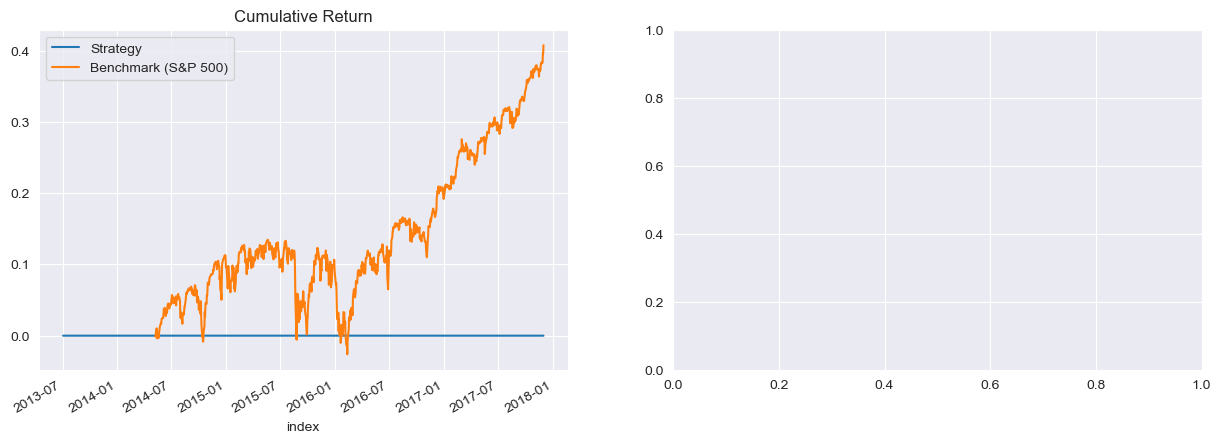

In [73]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

df = returns.to_frame('Strategy').join(benchmark.to_frame('Benchmark (S&P 500)'))
df.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')

longs.plot(label='Long',ax=axes[1], title='Positions')
shorts.plot(ax=axes[1], label='Short')
positions.cash.plot(ax=axes[1], label='PF Value')
axes[1].legend()
sns.despine()
fig.tight_layout();

In [74]:
pf.create_full_tear_sheet(returns,
                          transactions=transactions,
                          positions=positions,
                          benchmark_rets=benchmark.dropna())

KeyError: "[Timestamp('2014-05-26 00:00:00+0000', tz='UTC'), Timestamp('2014-07-04 00:00:00+0000', tz='UTC'), Timestamp('2014-09-01 00:00:00+0000', tz='UTC'), Timestamp('2014-11-27 00:00:00+0000', tz='UTC'), Timestamp('2014-12-25 00:00:00+0000', tz='UTC'), Timestamp('2015-01-01 00:00:00+0000', tz='UTC'), Timestamp('2015-01-19 00:00:00+0000', tz='UTC'), Timestamp('2015-02-16 00:00:00+0000', tz='UTC'), Timestamp('2015-04-03 00:00:00+0000', tz='UTC'), Timestamp('2015-05-25 00:00:00+0000', tz='UTC'), Timestamp('2015-07-03 00:00:00+0000', tz='UTC'), Timestamp('2015-09-07 00:00:00+0000', tz='UTC'), Timestamp('2015-11-26 00:00:00+0000', tz='UTC'), Timestamp('2015-12-25 00:00:00+0000', tz='UTC'), Timestamp('2016-01-01 00:00:00+0000', tz='UTC'), Timestamp('2016-01-18 00:00:00+0000', tz='UTC'), Timestamp('2016-02-15 00:00:00+0000', tz='UTC'), Timestamp('2016-03-25 00:00:00+0000', tz='UTC'), Timestamp('2016-05-30 00:00:00+0000', tz='UTC'), Timestamp('2016-07-04 00:00:00+0000', tz='UTC'), Timestamp('2016-09-05 00:00:00+0000', tz='UTC'), Timestamp('2016-11-24 00:00:00+0000', tz='UTC'), Timestamp('2016-12-26 00:00:00+0000', tz='UTC'), Timestamp('2017-01-02 00:00:00+0000', tz='UTC'), Timestamp('2017-01-16 00:00:00+0000', tz='UTC'), Timestamp('2017-02-20 00:00:00+0000', tz='UTC'), Timestamp('2017-05-29 00:00:00+0000', tz='UTC'), Timestamp('2017-07-04 00:00:00+0000', tz='UTC'), Timestamp('2017-09-04 00:00:00+0000', tz='UTC'), Timestamp('2017-11-08 00:00:00+0000', tz='UTC'), Timestamp('2017-11-23 00:00:00+0000', tz='UTC'), Timestamp('2017-12-01 00:00:00+0000', tz='UTC'), Timestamp('2017-12-04 00:00:00+0000', tz='UTC'), Timestamp('2017-12-05 00:00:00+0000', tz='UTC'), Timestamp('2017-12-06 00:00:00+0000', tz='UTC'), Timestamp('2017-12-07 00:00:00+0000', tz='UTC'), Timestamp('2017-12-08 00:00:00+0000', tz='UTC'), Timestamp('2017-12-11 00:00:00+0000', tz='UTC'), Timestamp('2017-12-12 00:00:00+0000', tz='UTC'), Timestamp('2017-12-13 00:00:00+0000', tz='UTC'), Timestamp('2017-12-14 00:00:00+0000', tz='UTC'), Timestamp('2017-12-15 00:00:00+0000', tz='UTC'), Timestamp('2017-12-18 00:00:00+0000', tz='UTC'), Timestamp('2017-12-19 00:00:00+0000', tz='UTC'), Timestamp('2017-12-20 00:00:00+0000', tz='UTC'), Timestamp('2017-12-21 00:00:00+0000', tz='UTC'), Timestamp('2017-12-22 00:00:00+0000', tz='UTC'), Timestamp('2017-12-25 00:00:00+0000', tz='UTC'), Timestamp('2017-12-26 00:00:00+0000', tz='UTC'), Timestamp('2017-12-27 00:00:00+0000', tz='UTC'), Timestamp('2017-12-28 00:00:00+0000', tz='UTC'), Timestamp('2017-12-29 00:00:00+0000', tz='UTC'), Timestamp('2018-01-01 00:00:00+0000', tz='UTC')] not in index"